In [5]:
import json
import time
import random
import pymongo
import copy
import MyCommon
from pymongo import MongoClient
from collections import deque
import cassiopeia
from cassiopeia import riotapi
import numpy as np
from sklearn import preprocessing, cluster, decomposition
from scipy.cluster.vq import kmeans,vq
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.decomposition import FastICA, PCA
from sklearn import metrics

riotapi.set_region("KR")
riotapi.set_api_key("79428a9e-5d98-469b-9b9b-429c1a750d24")
riotapi.set_rate_limits((10, 10), (500, 600))
riotapi.print_calls(True)

client = MongoClient()
loladb = client.loladb
summoners_collection = loladb.summoners
matches_collection = loladb.matches
print summoners_collection.count()
print matches_collection.count()

1255
25451


In [6]:
champions = riotapi.get_champions()
dict_id2idx = dict()
dict_idx2id = dict()
dict_id2key = dict()
for a_idx, a_champion in enumerate(champions):
    champ_id = a_champion.id
    champ_key = a_champion.key
    dict_id2idx[champ_id] = a_idx
    dict_idx2id[a_idx] = champ_id
    dict_id2key[champ_id] = champ_key
    
#print dict_id2key[dict_idx2id[132]]
#print dict_id2key

def GetIdxFromId(a_id):
    return dict_id2idx[a_id]

def GetIdFromIdx(a_idx):
    return dict_idx2id[a_idx]

def GetNameFromId(a_id):
    return dict_id2key[a_id]

https://global.api.pvp.net/api/lol/static-data/kr/v1.2/champion?champData=all&api_key=79428a9e-5d98-469b-9b9b-429c1a750d24
https://global.api.pvp.net/api/lol/static-data/kr/v1.2/item?itemListData=all&api_key=79428a9e-5d98-469b-9b9b-429c1a750d24


('Coefficients: \n', array([ 938.23786125]))
Mean squared error: 2548.07
Variance score: 0.47


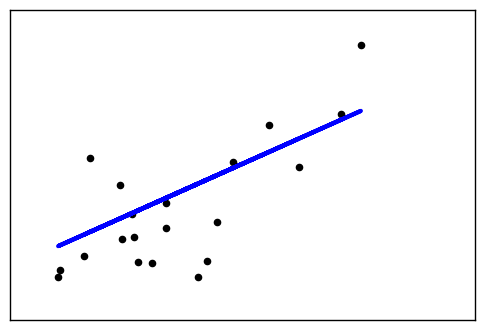

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model

diabetes = datasets.load_diabetes()


# Use only one feature
diabetes_X = diabetes.data[:, np.newaxis, 2]

# Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]

# Split the targets into training/testing sets
diabetes_y_train = diabetes.target[:-20]
diabetes_y_test = diabetes.target[-20:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((regr.predict(diabetes_X_test) - diabetes_y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(diabetes_X_test, diabetes_y_test))

# Plot outputs
plt.scatter(diabetes_X_test, diabetes_y_test,  color='black')
plt.plot(diabetes_X_test, regr.predict(diabetes_X_test), color='blue',
         linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [7]:
CHAMP_NUM = 133
TRAIN_NUM = 12000
TEST_NUM = 6000
Train_X = np.zeros((TRAIN_NUM * 2, CHAMP_NUM*2))
Train_Y = np.zeros((TRAIN_NUM * 2)) #value = 0 if blue wins

Test_X = np.zeros((TEST_NUM, CHAMP_NUM*2))
Test_Y = np.zeros((TRAIN_NUM)) #value = 0 if blue wins

train_idx = 0
train_end_idx = 0

isTest = False

for a_idx, a_match in enumerate(matches_collection.find({'matchVersion':'6.24.168.1268'})):
    winning_side = -1
    if a_match['teams'][0]['winner'] == True and a_match['teams'][1]['winner'] == False:
        winning_side = 0
    if a_match['teams'][0]['winner'] == False and a_match['teams'][1]['winner'] == True:
        winning_side = 1 
    if winning_side == -1:
        continue #do not count draw game, if any

    a_duration = a_match['matchDuration']
    a_minute = a_duration/60
    if a_minute < 20:
        continue #do not count remake game
        
    participants = a_match['participants']
    participantIds = [p['championId'] for p in participants]
    
    if 164 in participantIds:
        continue
    
    if isTest == False:
        for blue_id in participantIds[0:5]:
            #blue team
            blue_idx = GetIdxFromId(blue_id)
            Train_X[train_idx, blue_idx] = 1

        for red_id in participantIds[5:10]:
            #red team
            red_idx = GetIdxFromId(red_id)
            Train_X[train_idx, red_idx + CHAMP_NUM] = 1    

        Train_Y[train_idx] = winning_side
        
        #put the swaping result in train_idx + TRAIN_NUM
    
        for blue_id in participantIds[0:5]:
            #blue team
            blue_idx = GetIdxFromId(blue_id)
            Train_X[train_idx + TRAIN_NUM, blue_idx + CHAMP_NUM] = 1

        for red_id in participantIds[5:10]:
            #red team
            red_idx = GetIdxFromId(red_id)
            Train_X[train_idx + TRAIN_NUM, red_idx] = 1    

        Train_Y[train_idx + TRAIN_NUM] = 1 - winning_side
    else:
        for blue_id in participantIds[0:5]:
            #blue team
            blue_idx = GetIdxFromId(blue_id)
            Test_X[train_idx - train_end_idx, blue_idx] = 1

        for red_id in participantIds[5:10]:
            #red team
            red_idx = GetIdxFromId(red_id)
            Test_X[train_idx - train_end_idx, red_idx + CHAMP_NUM] = 1    

        Test_Y[train_idx - train_end_idx] = winning_side
    
    train_idx += 1
    if train_idx == TRAIN_NUM:
        train_end_idx = train_idx
        isTest = True
        
    if a_idx % 1000 == 0:
        print a_idx

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000


In [16]:
regr = linear_model.LogisticRegression()

# Train the model using the training sets
regr.fit(Train_X, Train_Y)

Eval_Y = regr.predict(Train_X)
#Correct_Y = Test_Y == Eval_Y
#print sum(Correct_Y)
#print len(Test_Y)
print Eval_Y

[ 1.  0.  0. ...,  0.  0.  0.]


In [17]:
Result_Y = Eval_Y == Train_Y

In [18]:
print Result_Y[0:10]
print Eval_Y[0:10]
print Train_Y[0:10]
print sum(Result_Y)

[False  True  True  True False  True  True  True  True False]
[ 1.  0.  0.  0.  1.  1.  1.  0.  1.  1.]
[ 0.  0.  0.  0.  0.  1.  1.  0.  1.  0.]
13711


In [19]:
print Train_X.shape

(24000, 266)


In [48]:
print 9193.0/16000.0

0.5745625


In [51]:
print Train_X[15998]
print Train_Y[15998]

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

In [8]:
from sklearn import svm
clf = svm.SVC()
clf.fit(Train_X, Train_Y) 
score = clf.score(Train_X, Train_Y)
print score

0.563083333333


In [9]:
score = clf.score(Test_X, Test_Y)
print score

ValueError: Found input variables with inconsistent numbers of samples: [12000, 6000]